# Handwritting Text Recognition CNN BiLSTM with CTC

This pipeline was implemented from [Naveen Reddy Marthala](https://github.com/naveenmarthala/Handwritten-word-recognition-OCR----IAM-dataset---CNN-and-BiRNN/blob/master/notebooks/iam%20on%20july%2025-CNN-BiLSTM.ipynb) Project. <br> But only recognize Alphanumeric character.

The trained model is only capable of recognizing short words composed of alphanumeric characters. It will not be able to predict or accurately handle punctuation, as those characters were deliberately excluded from the models vocabulary and the training data due to resource limitations.

## Import Libraries

In [26]:
import cv2
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
import string
%matplotlib inline
import pandas as pd

Because the model have almost 8 million params, we use GPU (RTX 3050 Laptop) for train model.

In [27]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
DATA_DIR = "IAM_Words"
IMG_DIR = os.path.join(DATA_DIR, "words")
# ANNOTATION = os.path.join(DATA_DIR, "words.txt")
TRAIN_LABEL = os.path.join(DATA_DIR, "train_files.txt")
VALID_LABEL = os.path.join(DATA_DIR, "valid_files.txt")
TEST_LABEL = os.path.join(DATA_DIR, "test_files.txt")
MODEL = "HwTR_V3.h5"

In [29]:
def load_img_path_n_text(file):
    """
    read a string like(which can be found in each line of words.txt file):
    'a01-000u-00-00 ok 154 408 768 27 51 AT A'
    and extract 'a01-000u-00-00': location of the image with sub-folders, to read it from the directories
                'ok'            : processing status. ok means good, presumably.
                'A'             : ground truth text

    Then, pre-process using function defined above
    """
    
    dataset = []
    skipped = 0
    with open(file) as f:
        for line in f:
            if not line or line.startswith('#'):
                continue

            line_split = line.strip().split(' ')
            
            # not load 'err'
            if line_split[1] == 'err':
                skipped +=1
                continue

            dir_split = line_split[0].split('-')
            img_path = os.path.join(IMG_DIR, dir_split[0], f"{dir_split[0]}-{dir_split[1]}",f"{line_split[0]}.png")

            gt_text = ' '.join(line_split[8:])

            if len(gt_text) > 16: # change into 16 max seq len
                skipped+=1
                continue

            if any(ch in string.punctuation for ch in gt_text):
                skipped += 1
                continue
            
            print(f"load : {img_path}, texts : {gt_text}")
            dataset.append([img_path, gt_text])

    print(f"skipped = {skipped}")
    return dataset

In [30]:
def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad


def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    """ Pre-processing image for predicting """
    img = cv2.imread(path)
    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # type: ignore

    img = img.astype(np.float32)
    img /= 255
    return img

In [31]:
letters = (
    [' '] +
    [str(d) for d in range(10)] +
    [chr(c) for c in range(ord('A'), ord('Z')+1)] +
    [chr(c) for c in range(ord('a'), ord('z')+1)]
)

num_classes = len(letters) + 1  # +1 for CTC blank
print(num_classes)

64


In [32]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

In [33]:
train_files = load_img_path_n_text(TRAIN_LABEL)
valid_files = load_img_path_n_text(VALID_LABEL)
test_files = load_img_path_n_text(TEST_LABEL)


load : IAM_Words\words\b06\b06-045\b06-045-07-01.png, texts : policy
load : IAM_Words\words\h07\h07-066a\h07-066a-02-04.png, texts : towns
load : IAM_Words\words\e06\e06-021\e06-021-07-02.png, texts : Being
load : IAM_Words\words\c03\c03-087a\c03-087a-06-03.png, texts : had
load : IAM_Words\words\g06\g06-018d\g06-018d-06-06.png, texts : high
load : IAM_Words\words\k04\k04-022\k04-022-07-02.png, texts : now
load : IAM_Words\words\h06\h06-092\h06-092-04-02.png, texts : a
load : IAM_Words\words\p03\p03-112\p03-112-02-04.png, texts : moment
load : IAM_Words\words\j01\j01-059\j01-059-00-00.png, texts : Provided
load : IAM_Words\words\m04\m04-000\m04-000-06-04.png, texts : the
load : IAM_Words\words\l07\l07-111\l07-111-07-03.png, texts : a
load : IAM_Words\words\e01\e01-014\e01-014-03-01.png, texts : mean
load : IAM_Words\words\a02\a02-120\a02-120-00-01.png, texts : possibility
load : IAM_Words\words\n06\n06-119\n06-119-05-01.png, texts : vast
load : IAM_Words\words\g04\g04-092\g04-092-08-02

In [34]:
print(f"Train = {len(train_files)}")
print(f"Valid = {len(valid_files)}")
print(f"Test = {len(test_files)}")

Train = 74888
Valid = 3670
Test = 3732


In [35]:
for index, (img_loc, gt_text) in enumerate(train_files):
    if 'r06-022-03-05' in img_loc:
        print(index)
        print(train_files[index])
        del train_files[index]
        print(train_files[index])
    else:
        continue

3936
['IAM_Words\\words\\r06\\r06-022\\r06-022-03-05.png', 'more']
['IAM_Words\\words\\g06\\g06-042e\\g06-042e-05-03.png', 'notice']


done


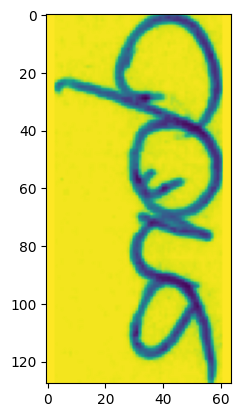

In [36]:
i = 21
print(train_files[i][1])
# print("Exists:", os.path.exists(train_files[i][0]))
an_img = preprocess(path=train_files[i][0], img_w=128, img_h=64)
plt.imshow(an_img.T)

In [37]:
class TextImageGenerator:
    def __init__(self, data, img_w, img_h,  batch_size,  i_len, max_text_len):
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.samples = data
        self.n = len(self.samples)
        self.i_len = i_len
        self.indexes = list(range(self.n))
        self.cur_index = 0

    def build_data(self):
        self.texts = [text for _, text in self.samples]
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        
        img_path, text = self.samples[self.indexes[self.cur_index]]
        img = preprocess(img_path, self.img_w, self.img_h)
        return img, text
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * self.i_len
            label_length = np.zeros((self.batch_size, 1))
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i, :len(text)] = text_to_labels(text)
                label_length[i] = len(text)
                
            inputs = [X_data, Y_data, input_length, label_length]
            outputs = np.zeros([self.batch_size])
            yield (inputs, outputs)

    def peek_images(self, n=5):
        """
        Load and return the first n images and their texts for inspection.
        Does NOT preload the whole dataset.
        """
        peek_imgs = []
        peek_texts = []
        
        for i in range(min(n, self.n)):
            img_path, text = self.samples[i]
            img = preprocess(img_path, self.img_w, self.img_h)
            peek_imgs.append(img)
            peek_texts.append(text)
            
        return np.array(peek_imgs), peek_texts

In [38]:
BATCH_SIZE = 64
INPUT_LENGHT = 30
MAX_TEXT_LENGTH = 16
IMG_W = 128
IMG_H = 64
EPOCHS = 40

In [39]:
train_data = TextImageGenerator(train_files, IMG_W, IMG_H, BATCH_SIZE, INPUT_LENGHT, MAX_TEXT_LENGTH)
train_data.build_data()

In [40]:
images, texts = train_data.peek_images(n=3)
print("Peek images shape:", images.shape)  # (3, img_h, img_w)
print("Texts:", texts)

Peek images shape: (3, 64, 128)
Texts: ['policy', 'towns', 'Being']


In [41]:
valid_data = TextImageGenerator(valid_files, IMG_W, IMG_H, BATCH_SIZE, INPUT_LENGHT, MAX_TEXT_LENGTH)
valid_data.build_data()

In [42]:
images, texts = valid_data.peek_images(n=3)
print("Peek images shape:", images.shape)  # (3, img_h, img_w)
print("Texts:", texts)

Peek images shape: (3, 64, 128)
Texts: ['latter', 'possible', 'that']


In [43]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as F

F.set_image_data_format('channels_last')
F.image_data_format()
     

'channels_last'

In [44]:
input_data = layers.Input(name='input', shape=(IMG_W,IMG_H,1), dtype='float32')  # (None, 128, 64, 1)

# Convolution layer (VGG)
x = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), name='max1')(x)  # (None,64, 32, 64)

x = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), name='max2')(x)

x = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(1, 2), name='max3')(x)  # (None, 32, 8, 256)

x = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(1, 2), name='max4')(x)

x = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Dropout(0.3, name='dropout_cnn_output')(x)

# CNN to RNN
x = layers.Reshape(target_shape=((32, 2048)), name='reshape')(x)
x = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(x)

# RNN layer
# layer ten
x = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(x)
x = layers.Dropout(0.3, name='dropout_bilstm_mid')(x)

# layer nine
x = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(x)
x = layers.BatchNormalization()(x)

# transforms RNN output to character activations:
x = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(x)
iam_outputs = layers.Activation('softmax', name='softmax')(x)

labels = layers.Input(name='the_labels', shape=[16], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return F.ctc_batch_cost(labels, y_pred, input_length, label_length)


# loss function
loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 64, 64)  640         ['input[0][0]']                  
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 128, 64, 64)  256        ['conv1[0][0]']                  
 rmalization)                                                                                     
                                                                                            

In [45]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

In [46]:
import time
from tensorflow.keras.callbacks import Callback

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
        self.train_epoch_times.append(cur_epoch_time)
        print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))


    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        print(" ;validation took {} minutes.".format(cur_test_time))

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_save_cb = ModelCheckpoint(filepath=os.path.join("save", "{epoch:03}-val_loss{val_loss:.3f}.h5"),
                                verbose=1, save_best_only=False, monitor='val_loss', save_weights_only=False)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min')
# reduce_learning_rate_cb = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.00001, verbose=1)
epoch_times = EpochTimeHistory()

In [48]:
BATCH_SIZE, train_data.n, valid_data.n

(64, 74887, 3670)

In [49]:
history_model_3 = model.fit(train_data.next_batch(),
                            validation_data=valid_data.next_batch(),
                            steps_per_epoch=train_data.n/BATCH_SIZE,
                            validation_steps=valid_data.n // BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks=[earlystop, model_save_cb, epoch_times])

Epoch 1/40
1171/1170 [==============================] - ETA: 0s - loss: 8.7390 ;validation took 0.6708 minutes.

Epoch 1: saving model to save\001-val_loss3.420.h5
 ;epoch 1 took 15.2725 minutes.
1170/1170 [==============================] - 916s 775ms/step - loss: 8.7390 - val_loss: 3.4204
Epoch 2/40
1171/1170 [==============================] - ETA: 0s - loss: 2.6178 ;validation took 0.0971 minutes.

Epoch 2: saving model to save\002-val_loss6.061.h5
 ;epoch 2 took 12.5256 minutes.
1170/1170 [==============================] - 752s 643ms/step - loss: 2.6178 - val_loss: 6.0610
Epoch 3/40
1171/1170 [==============================] - ETA: 0s - loss: 1.8152 ;validation took 0.0986 minutes.

Epoch 3: saving model to save\003-val_loss1.565.h5
 ;epoch 3 took 13.0685 minutes.
1170/1170 [==============================] - 784s 670ms/step - loss: 1.8152 - val_loss: 1.5650
Epoch 4/40
1171/1170 [==============================] - ETA: 0s - loss: 1.4612 ;validation took 0.0953 minutes.

Epoch 4: savin

In [50]:
model.save(MODEL)

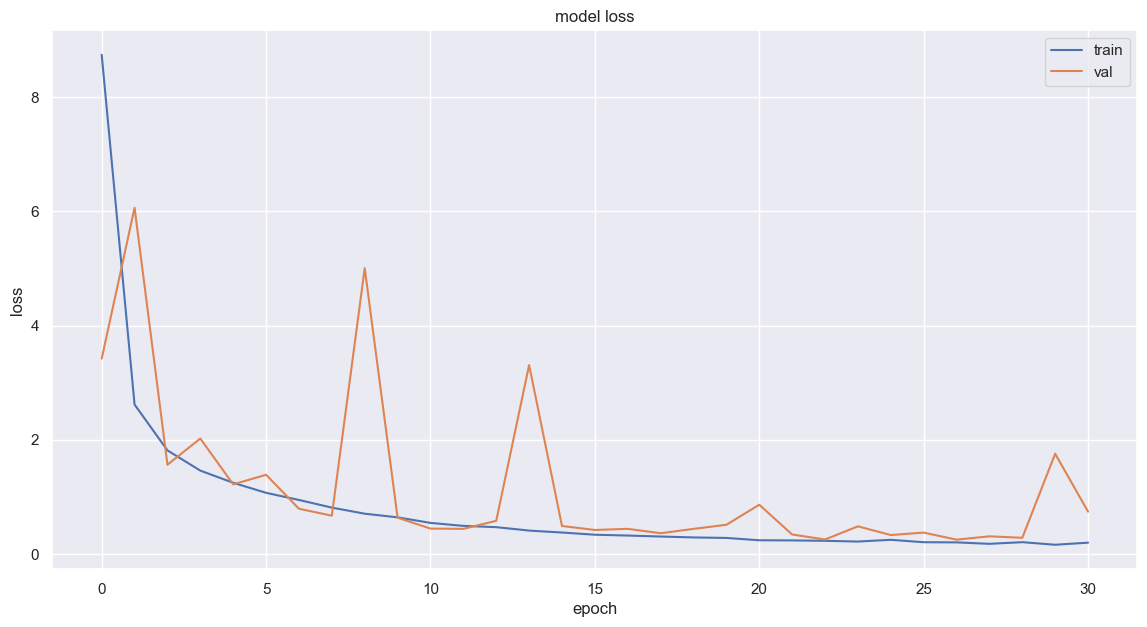

In [51]:
sns.set(rc={'figure.figsize':(14,7)})
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [52]:
history_model_3.history.keys()

dict_keys(['loss', 'val_loss'])

In [53]:
loss_df = pd.DataFrame(data=history_model_3.history)
loss_df.head()

loss  val_loss
0  8.738966  3.420390
1  2.617772  6.060956
2  1.815210  1.564973
3  1.461212  2.022847
4  1.248524  1.220767

In [54]:
loss_df.sort_values(by=['loss', 'val_loss']).head()

loss  val_loss
29  0.164043  1.756979
27  0.180217  0.311367
30  0.200556  0.743626
26  0.205462  0.253321
25  0.208263  0.376681

biographies


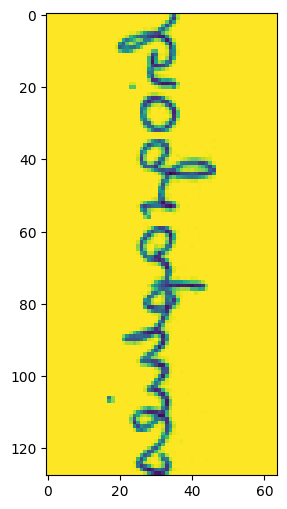

In [55]:
sns.reset_orig()
plt.figure(figsize=(3, 6))
i = 1
print(test_files[i][1])
temp_processed_image = preprocess(path=test_files[i][0], img_w=128, img_h=64)
plt.imshow(temp_processed_image.T)
plt.show()

In [56]:
test_images_processed = []
original_test_texts = []
for _, (test_image_path, original_test_text) in enumerate(test_files):
     temp_processed_image = preprocess(path=test_image_path, img_w=128, img_h=64)
     test_images_processed.append(temp_processed_image.T)
     original_test_texts.append(original_test_text)

In [57]:
test_images_processed = np.array(test_images_processed)
test_images_processed.shape

(3732, 128, 64)

In [58]:
test_images_processed = test_images_processed.reshape(3732, 128, 64, 1)
test_images_processed.shape

(3732, 128, 64, 1)

biographies


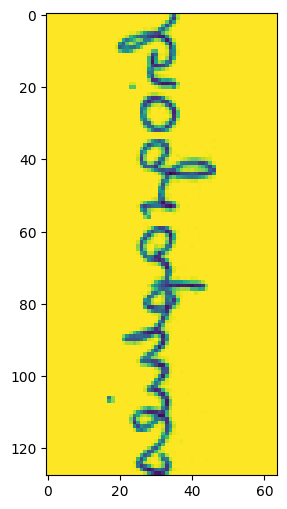

In [59]:
sns.reset_orig()
plt.figure(figsize=(3, 6))
i = 1
print(test_files[i][1])
plt.imshow(test_images_processed[i].reshape(128,64))
plt.show()

In [60]:
model_pred = None
model_pred = Model(inputs=input_data, outputs=iam_outputs)
model_pred.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 128, 64, 64)       640       
                                                                 
 batch_normalization_8 (Batc  (None, 128, 64, 64)      256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 128, 64, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 64, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 64, 32, 128)       73856     
                                                           

In [61]:
model_pred.load_weights(MODEL)

In [62]:
test_predictions_encoded = model_pred.predict(x=test_images_processed)
test_predictions_encoded.shape

117/117 [==============================] - 9s 48ms/step


(3732, 32, 80)

In [63]:
# use CTC decoder to decode to text
test_predictions_decoded = F.get_value(F.ctc_decode(test_predictions_encoded,
    input_length = np.ones(test_predictions_encoded.shape[0])*test_predictions_encoded.shape[1],
    greedy=True)[0][0])
test_predictions_decoded.shape

(3732, 32)

In [64]:
VOCAB_SIZE = len(letters) 
def numbered_array_to_text(numbered_array):
    # delete padding
    numbered_array = numbered_array[numbered_array != -1]
    # fix vocab without punctuation
    numbered_array = numbered_array[numbered_array < VOCAB_SIZE] 
    return "".join(letters[i] for i in numbered_array)

In [65]:
for i in range(10):
    print("original_text = ", original_test_texts[i])
    print("predicted text = ", numbered_array_to_text(test_predictions_decoded[i]))
    print()

original_text =  certain
predicted text =  certain

original_text =  biographies
predicted text =  biograpties

original_text =  all
predicted text =  all

original_text =  It
predicted text =  It

original_text =  I
predicted text =  I

original_text =  show
predicted text =  show

original_text =  Kings
predicted text =  Kkings

original_text =  A
predicted text =  A

original_text =  the
predicted text =  the

original_text =  and
predicted text =  and



In [66]:
def levenshtein_distance(s1, s2):
    """
    Menghitung Jarak Levenshtein antara dua string (s1 dan s2).
    Menggunakan algoritma Dynamic Programming.
    """
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    # Inisialisasi matriks jarak
    distances = range(len(s1) + 1)
    
    # Iterasi melalui string kedua (s2)
    for i2, c2 in enumerate(s2):
        new_distances = [i2 + 1]
        
        # Iterasi melalui string pertama (s1)
        for i1, c1 in enumerate(s1):
            
            # Cost (biaya) substitusi: 0 jika karakter sama, 1 jika berbeda
            if c1 == c2:
                cost = 0
            else:
                cost = 1
                
            # Pilih nilai minimum dari 3 operasi:
            # 1. Delesi (distances[i1 + 1] + 1)
            # 2. Insersi (new_distances[-1] + 1)
            # 3. Substitusi (distances[i1] + cost)
            new_distances.append(min(new_distances[-1] + 1,
                                     distances[i1] + cost,
                                     distances[i1 + 1] + 1))
            
        distances = new_distances
        
    return distances[-1]

def calculate_cer_manual(original_text, predicted_text):
    """
    Menghitung Character Error Rate (CER) menggunakan Levenshtein Distance manual.
    """
    
    # Hitung Jarak Levenshtein (S + I + D) pada karakter
    distance = levenshtein_distance(original_text, predicted_text)
    
    # Total elemen (denominator) adalah panjang karakter teks asli
    total_chars = len(original_text)
    
    if total_chars == 0:
        return 0.0
        
    return distance / total_chars

def calculate_wer_manual(original_text, predicted_text):
    """
    Menghitung Word Error Rate (WER) menggunakan Levenshtein Distance manual.
    """
    
    # 1. Pisahkan string menjadi daftar kata
    original_words = original_text.split()
    predicted_words = predicted_text.split()
    
    # 2. Hitung Jarak Levenshtein pada daftar kata (bukan string)
    distance = levenshtein_distance(original_words, predicted_words)
    
    # 3. Total elemen (denominator) adalah jumlah kata teks asli
    total_words = len(original_words)
    
    if total_words == 0:
        return 0.0
        
    return distance / total_words



In [67]:
all_cer_scores = []
all_wer_scores = []

for i in range(len(original_test_texts)):
    original_text = original_test_texts[i]
    predicted_text_raw = numbered_array_to_text(test_predictions_decoded[i])
    
    # Membersihkan prediksi untuk hasil WER/CER yang akurat
    # Hapus spasi ganda (double spaces) dan strip spasi di awal/akhir
    predicted_text = ' '.join(predicted_text_raw.split()).strip()

    # Hitung CER dan WER
    cer_score = calculate_cer_manual(original_text, predicted_text)
    wer_score = calculate_wer_manual(original_text, predicted_text)
    
    all_cer_scores.append(cer_score)
    all_wer_scores.append(wer_score)
    
    # Tampilkan 10 sampel pertama (Opsional)
    if i < 10:
        print(f"Original: {original_text}")
        print(f"Predicted: {predicted_text}")
        print(f"CER: {cer_score:.4f}, WER: {wer_score:.4f}\n")


# Hitung Rata-Rata Akhir
final_avg_cer = np.mean(all_cer_scores)
final_avg_wer = np.mean(all_wer_scores)

print("="*40)
print(f"FINAL AVERAGE CER: {final_avg_cer:.4f}")
print(f"FINAL AVERAGE WER: {final_avg_wer:.4f}")
print("="*40)

Original: certain
Predicted: certain
CER: 0.0000, WER: 0.0000

Original: biographies
Predicted: biograpties
CER: 0.0909, WER: 1.0000

Original: all
Predicted: all
CER: 0.0000, WER: 0.0000

Original: It
Predicted: It
CER: 0.0000, WER: 0.0000

Original: I
Predicted: I
CER: 0.0000, WER: 0.0000

Original: show
Predicted: show
CER: 0.0000, WER: 0.0000

Original: Kings
Predicted: Kkings
CER: 0.2000, WER: 1.0000

Original: A
Predicted: A
CER: 0.0000, WER: 0.0000

Original: the
Predicted: the
CER: 0.0000, WER: 0.0000

Original: and
Predicted: and
CER: 0.0000, WER: 0.0000

FINAL AVERAGE CER: 0.1244
FINAL AVERAGE WER: 0.3783
